### Load Environment and Initialize OpenAI Models

This cell sets up the chat model (LLM) and the embedding model, and creates a Chroma vector store to store blog chunks for retrieval.


In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma

# Create LLM and Embedding models
llm = ChatOpenAI(model="gpt-4o", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Create persistent vector store
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db"
)

/Users/anojanyogenthiran/Documents/Projects/rag-langchain-tutorial/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Load and Chunk Blog Content

We use `WebBaseLoader` to fetch the blog post and `RecursiveCharacterTextSplitter` to divide it into overlapping chunks.


In [2]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load blog HTML from the specified URL
loader = WebBaseLoader(
    web_paths=["https://lilianweng.github.io/posts/2023-06-23-agent/"],
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))
    )
)

docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43130


In [3]:
# Split the text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, # chunk size (characters)
    chunk_overlap=200 # chunk overlap (characters)
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


### Index Chunks in the Vector Store

Now we store the blog content in Chroma so we can search it later.


In [4]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['25080bc7-7cfb-4304-84e8-5decdcb4e14a', '92ec8668-0cba-45f4-ae9b-29e435c09ae3', '3341cc29-c581-4de9-81ba-c72cae228762']


### Set Up Prompt and Application State

This cell defines the structure of the RAG pipeline using LangGraph's `StateGraph`.


In [5]:
from langchain import hub
from langgraph.graph import START, StateGraph
from langchain_core.documents import Document
from typing_extensions import TypedDict, List

# Load prompt from LangChain hub
prompt = hub.pull("rlm/rag-prompt")

# Define graph state
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

### Define Retrieval and Generation Functions

`retrieve()` finds relevant chunks, `generate()` builds the final answer using the LLM.


In [6]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

### Compile and Run the RAG App

We compile the graph and test it with a question to see the end-to-end result.


In [7]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

# Run a test query
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition is a technique used to break down complex tasks into smaller, more manageable steps. It involves using methods like Chain of Thought (CoT) to enhance model performance by instructing the model to "think step by step." This approach allows for a clearer interpretation of the model's reasoning process and can be implemented through simple prompting, task-specific instructions, or human inputs.


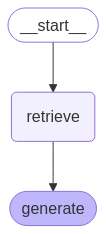

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='3341cc29-c581-4de9-81ba-c72cae228762', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='fe39455b-68cf-4e30-8533-f4febe8ce77b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibiliti